# imgaug 설치

In [1]:
!pip install six numpy scipy Pillow matplotlib scikit-image opencv-python imageio Shapely

In [2]:
!pip install imgaug

# 전처리

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn

In [5]:
# 이미지의 가로 세로
IMG_SIZE = 224
# 비디오에서 학습할 프레임 개수
MAX_SEQ_LENGTH = 20

In [6]:
# 데이터 경로
data_path = "/content/drive/MyDrive/인공지능 자연어처리 및 음성인식 음성합성 기술을 활용한 응용 SW 개발자 양성과정 /4.딥러닝_프로젝트/workspace/"

In [7]:
# 학습 데이터의 파일명과 종류가 저장된 train.csv 를 읽음
train_df = pd.read_csv(data_path + "train.csv")


In [8]:
train_df

,video_name,tag
0,v_CricketShot_g08_c01.avi,CricketShot
1,v_CricketShot_g08_c02.avi,CricketShot
2,v_CricketShot_g08_c03.avi,CricketShot
3,v_CricketShot_g08_c04.avi,CricketShot
4,v_CricketShot_g08_c05.avi,CricketShot
...,...,...
351,v_TennisSwing_g25_c02.avi,TennisSwing
352,v_TennisSwing_g25_c03.avi,TennisSwing
353,v_TennisSwing_g25_c04.avi,TennisSwing
354,v_TennisSwing_g25_c05.avi,TennisSwing


In [9]:
# 비디오의 종류가 저장된 tag 컬럼을 label 컬럼에 대입
train_df["label"] = train_df["tag"]

In [10]:
train_df

,video_name,tag,label
0,v_CricketShot_g08_c01.avi,CricketShot,CricketShot
1,v_CricketShot_g08_c02.avi,CricketShot,CricketShot
2,v_CricketShot_g08_c03.avi,CricketShot,CricketShot
3,v_CricketShot_g08_c04.avi,CricketShot,CricketShot
4,v_CricketShot_g08_c05.avi,CricketShot,CricketShot
...,...,...,...
351,v_TennisSwing_g25_c02.avi,TennisSwing,TennisSwing
352,v_TennisSwing_g25_c03.avi,TennisSwing,TennisSwing
353,v_TennisSwing_g25_c04.avi,TennisSwing,TennisSwing
354,v_TennisSwing_g25_c05.avi,TennisSwing,TennisSwing


In [11]:
# label 컬럼에 저장된 데이터를 중복을 제거하고 조회
train_df["label"].unique()

array(['CricketShot', 'Punch', 'TennisSwing'], dtype=object)

In [12]:
# enumerate(train_df["label"].unique()) : label 컬럼에 저장된 데이터를 중복을 제거한 값에 인덱스 추가
for index, data in enumerate(train_df["label"].unique()):
    # label 컬럼에 저장된 data 를 index로 변환
    train_df["label"].replace(data, index, inplace=True) 

In [13]:
# label 컬럼에 저장된 값이 숫자로 변환 되었음
train_df

,video_name,tag,label
0,v_CricketShot_g08_c01.avi,CricketShot,0
1,v_CricketShot_g08_c02.avi,CricketShot,0
2,v_CricketShot_g08_c03.avi,CricketShot,0
3,v_CricketShot_g08_c04.avi,CricketShot,0
4,v_CricketShot_g08_c05.avi,CricketShot,0
...,...,...,...
351,v_TennisSwing_g25_c02.avi,TennisSwing,2
352,v_TennisSwing_g25_c03.avi,TennisSwing,2
353,v_TennisSwing_g25_c04.avi,TennisSwing,2
354,v_TennisSwing_g25_c05.avi,TennisSwing,2


In [14]:
# sklearn.utils.shuffle(train_df) : train_df에 저장된 행을 섞음
train_df = sklearn.utils.shuffle(train_df)

In [15]:
# train_df에 저장된 줄이 섞였음
train_df

,video_name,tag,label
77,v_CricketShot_g19_c04.avi,CricketShot,0
34,v_CricketShot_g12_c07.avi,CricketShot,0
13,v_CricketShot_g09_c07.avi,CricketShot,0
218,v_Punch_g23_c01.avi,Punch,1
354,v_TennisSwing_g25_c05.avi,TennisSwing,2
...,...,...,...
353,v_TennisSwing_g25_c04.avi,TennisSwing,2
202,v_Punch_g20_c03.avi,Punch,1
296,v_TennisSwing_g16_c03.avi,TennisSwing,2
241,v_TennisSwing_g08_c03.avi,TennisSwing,2


In [16]:
# 비디오를 구성하는 이미지의 가운데 부분을 리턴
# frame : 비디오를 구성하는 이미지
def crop_center_square(frame):
    # frame.shape[0:2] : 이미지의 세로, 가로 리턴
    y, x = frame.shape[0:2]
    # 이미지의 세로 가로 중에서 작은 값을 리턴
    min_dim = min(y, x)
    #이미지의 왼쪽 모서리 좌표의 가로 시작점
    # 이미지 가로 좌표 (이미지 가로 //2  - min_dim//2) ~ (이미지 가로 //2  + min_dim//2) 
    start_x = (x // 2) - (min_dim // 2)
    # 이미지의 왼쪽 모서리 세로 좌표 시작점
    # 이미지 세로 좌표 (이미지 세로 //2  - min_dim//2) ~ (이미지 세로 //2  + min_dim//2) 
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [17]:
# 비디오 파일을 읽어서 각 프레임을 이미지로 변환해서 리턴
# path : 비디오 파일 경로
# max_frames : 이미지로 변환할 프레임수
# resize=(IMG_SIZE, IMG_SIZE) : 이미지의 가로 세로
def load_video(path, max_frames=20, resize=(IMG_SIZE, IMG_SIZE)):
    # 비디오 파일을 읽어서 이미지로 변환 할 객페
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            # cap.read() : 비디오를 읽어서 리턴
            # ret : 비디오 읽기가 성공했으면 True, 더이상 읽을 비디오 프레임이 없으면 False 가 리턴
            # frame : 비디오 프레임 이미지를 리턴
            ret, frame = cap.read()
            # ret 가 False면 반복 종료
            if not ret:
                break
            # 비디오 이미지를 가운데 리턴
            frame = crop_center_square(frame)
            #비디오 이미지의 가로 세로를 resize=(224,224) 로 변환
            frame = cv2.resize(frame, resize)
            # frame 은  [줄, 칸, B G R ] 로 구성되 있음 
            # frame [ : (모든줄), : (모든칸), R (인덱스2) G (인덱스1) B (인덱스0 )] 리턴
            frame = frame[:, :, [2, 1, 0]]
            # frame을 frames에 추가
            frames.append(frame)
            # frames에 저장된 데이터수가 max_frames와 같으면 종료
            if len(frames) == max_frames:
                break
    finally:
        # 비디오 이미지 변환 종료
        cap.release()
    # frames를 numpy 배열로 변환 해서 리턴
    return np.array(frames)


In [18]:
# video 파일명 리턴
train_df["video_name"].loc[0]

'v_CricketShot_g08_c01.avi'

In [19]:
# 비디오 파일의 프레임을 이미지로 변환해서 리턴
video = load_video(data_path+"train/"+train_df["video_name"].loc[0])

In [20]:
# 비디오 파일 프레임 이미지 조회
video

array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]],


       [[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0,

In [21]:
video.shape

(20, 224, 224, 3)

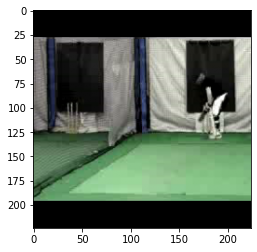

In [22]:
# 첫번째 프레임 출력
plt.imshow(video[0]/255)

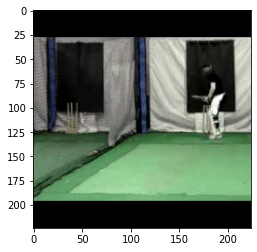

In [23]:
# 10번째 프레임 출력
plt.imshow(video[10]/255)

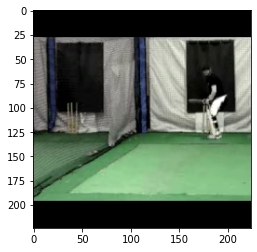

In [24]:
# 19번째 프레임 조회
plt.imshow(video[19]/255)

In [25]:
# 비디오 파일 종류 조회
train_df["label"].values

array([0, 0, 0, 1, 2, 2, 0, 2, 0, 2, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1, 1, 2,
       2, 2, 1, 2, 1, 1, 0, 2, 1, 0, 2, 1, 0, 0, 1, 0, 1, 2, 2, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 2, 1, 0, 1, 2, 1, 0, 1, 2, 2, 2, 0,
       1, 1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1,
       0, 1, 1, 2, 1, 2, 2, 2, 0, 2, 1, 2, 1, 0, 1, 2, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 2, 0, 1, 0, 2, 1, 0, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2,
       1, 2, 0, 1, 0, 2, 1, 1, 2, 1, 1, 2, 0, 1, 1, 2, 0, 1, 0, 2, 0, 0,
       0, 1, 1, 1, 2, 0, 1, 2, 0, 0, 1, 0, 1, 2, 0, 0, 1, 2, 0, 1, 0, 1,
       2, 1, 1, 1, 2, 0, 2, 0, 1, 0, 2, 0, 1, 0, 1, 0, 2, 2, 2, 1, 0, 2,
       1, 2, 0, 1, 2, 2, 1, 0, 1, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2,
       2, 1, 1, 0, 1, 2, 2, 0, 0, 1, 2, 2, 0, 2, 1, 0, 0, 2, 1, 2, 1, 0,
       1, 2, 0, 0, 0, 1, 2, 2, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 1, 0, 2, 1, 2, 0, 0, 2,
       1, 0, 2, 1, 2, 1, 0, 1, 2, 1, 2, 2, 2, 2, 1,

In [26]:
# 비디오 파일의 종류를 2차원 배열로 변환
train_df["label"].values.reshape(-1,1)

array([[0],
       [0],
       [0],
       [1],
       [2],
       [2],
       [0],
       [2],
       [0],
       [2],
       [2],
       [2],
       [2],
       [1],
       [0],
       [0],
       [2],
       [2],
       [0],
       [1],
       [1],
       [2],
       [2],
       [2],
       [1],
       [2],
       [1],
       [1],
       [0],
       [2],
       [1],
       [0],
       [2],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [2],
       [2],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [2],
       [1],
       [0],
       [1],
       [2],
       [1],
       [0],
       [1],
       [2],
       [2],
       [2],
       [0],
       [1],
       [1],
       [0],
       [1],
       [2],
       [2],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [1],
       [1],
       [1],
    

In [27]:
# 모든 비디오 파일의 이미지와 종류를 리턴
# video_name : 비디오 파일명
# label: 비디오 파일 종류
# root_dir : 비디오 파일 경로
def prepare_all_videos(video_name , label, root_dir):
    # 비디오 파일 이름의 개수
    num_samples = len(video_name)
    # video_name.values.tolist() : 비디오 파일 이름을 리스트로 변환 해서 리턴
    video_paths = video_name.values.tolist()
    # 비디오 종류를 리턴
    labels = label.values
    # 비디오 종류를 2차원 배열로 변환
    labels = labels.reshape(-1,1)
    # 0으로 초기화된 [비디오 파일개수 * 20 , 224 , 224, 3] 배열 생성
    x = np.zeros(shape=(num_samples*MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3 ), dtype="float32" )
    # 0으로 초기화된 [비디오파일개수 * 20] 인 배열 생성
    y = np.zeros(shape=(num_samples*MAX_SEQ_LENGTH), dtype="float32")
    # 인덱스 초기화
    index = 0
    # 비디오 파일의 개수 만큼 반복
    for idx, path in enumerate(video_paths):
        # 비디오 파일을 읽어서 각 프레임의 이미지를 리턴
        frames = load_video(root_dir+ path)
        # 프레임의 개수 만큼 반복
        for i in range(len(frames)):
            # frame의 i번째 이미지를 x에 추가
            x[index] = np.array(frames[i], dtype="float32")
            # 비디오의 종류가 저장된 labels의 idx 번째를 y에 추가
            y[index]= np.array(labels[idx], dtype="float32")
            # index 1 증가
            index += 1 
    
    # 전체 비디오 프레임을 이미지로 변환한 x 
    # to_categorical(y) : 이미지의 종류 y 를 onehot 인코딩 
    return (x,to_categorical(y))

In [28]:
# 비디오 프레임을 이미지로 변환한 데이터를 X_train에 저장
# 비디오 프레임 이미지의 종류를 y_train에 저장
X_train, y_train = prepare_all_videos(train_df["video_name"], train_df["label"] , data_path + "train/")

In [29]:
# 전체 비디오 프레임을 이미지로 변환한 데이터 조회
X_train

array([[[[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        ...,

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
       

In [30]:
X_train.shape

(7120, 224, 224, 3)

In [31]:
#비디오 종류
y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [32]:
y_train.shape

(7120, 3)

In [33]:
X_train[0].shape

(224, 224, 3)

In [34]:
#0번째 이미지 조회
X_train[0]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

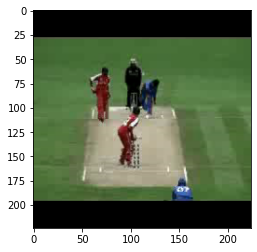

In [35]:
# 0번째  이미지
plt.imshow(X_train[0]/255)

In [36]:
# 0번째 이미지 종류
y_train[0]

array([1., 0., 0.], dtype=float32)

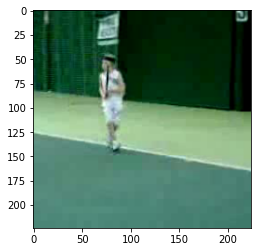

In [37]:
# 100번째  이미지
plt.imshow(X_train[100]/255)

In [38]:
# 100번째 이미지 종류
y_train[100]

array([0., 0., 1.], dtype=float32)

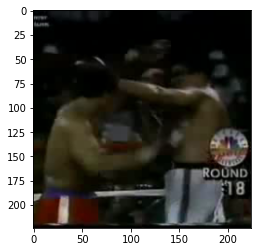

In [39]:
# 1000 번째 이미지
plt.imshow(X_train[1000]/255)

In [40]:
# 1000 번째 이미지 종류
y_train[1000]

array([0., 1., 0.], dtype=float32)

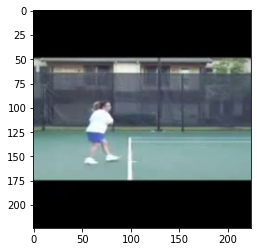

In [41]:
# 4759 번째  이미지
plt.imshow(X_train[4759]/255)

In [42]:
# 4759 번째 이미지 종류
y_train[4759]

array([0., 0., 1.], dtype=float32)

#모델 생성

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

In [44]:
# ResNet152 : ResNet152 객체를 리턴
#include_top=True : 이미지넷 대회처럼 1000 가지 이미지로 분류 
#include_top=False : 이미지는 분류하지 않고  이미지의 특성을 추출하는 필터와 맥스풀링만 사용
# input_shape=(224, 224, 3) : 입력 이미지의 크기 224줄 224칸 3 컬러
resnet = ResNet152V2( include_top=False,input_shape=(224, 224, 3))

In [45]:
# 이미지넷 대회에서 사용한 필터들의 값을 수정하지 않고 그대로 사용
resnet.trainable=False

In [46]:
resnet.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [47]:
from tensorflow.keras.utils import plot_model
#resnet 모델 시각화
plot_model(resnet, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

In [48]:
#입력값을 읽어서 예측을 할 Sequential 객체 생성
model = Sequential()

In [49]:
#vggnet 추가
model.add(resnet)

In [50]:
#선형 회귀를 하기 위해서 합성곱 연산을 수행한 결과를 1차원 배열로 변환
model.add(Flatten())

In [51]:
#Dense : 선형 회귀를 수행할 객체
#Dense(출력데이터의 칸의수) : 출력 데이터 칸의 수는 256 이므로
#Dense(256)  
# activation="relu" :선형 회귀 후 relu 활성 함수 사용
#model.add(Dense(256, activation='relu')) :Dense 모델을 예측 할 수 있도록 model에 추가
model.add(Dense(256, activation='relu'))

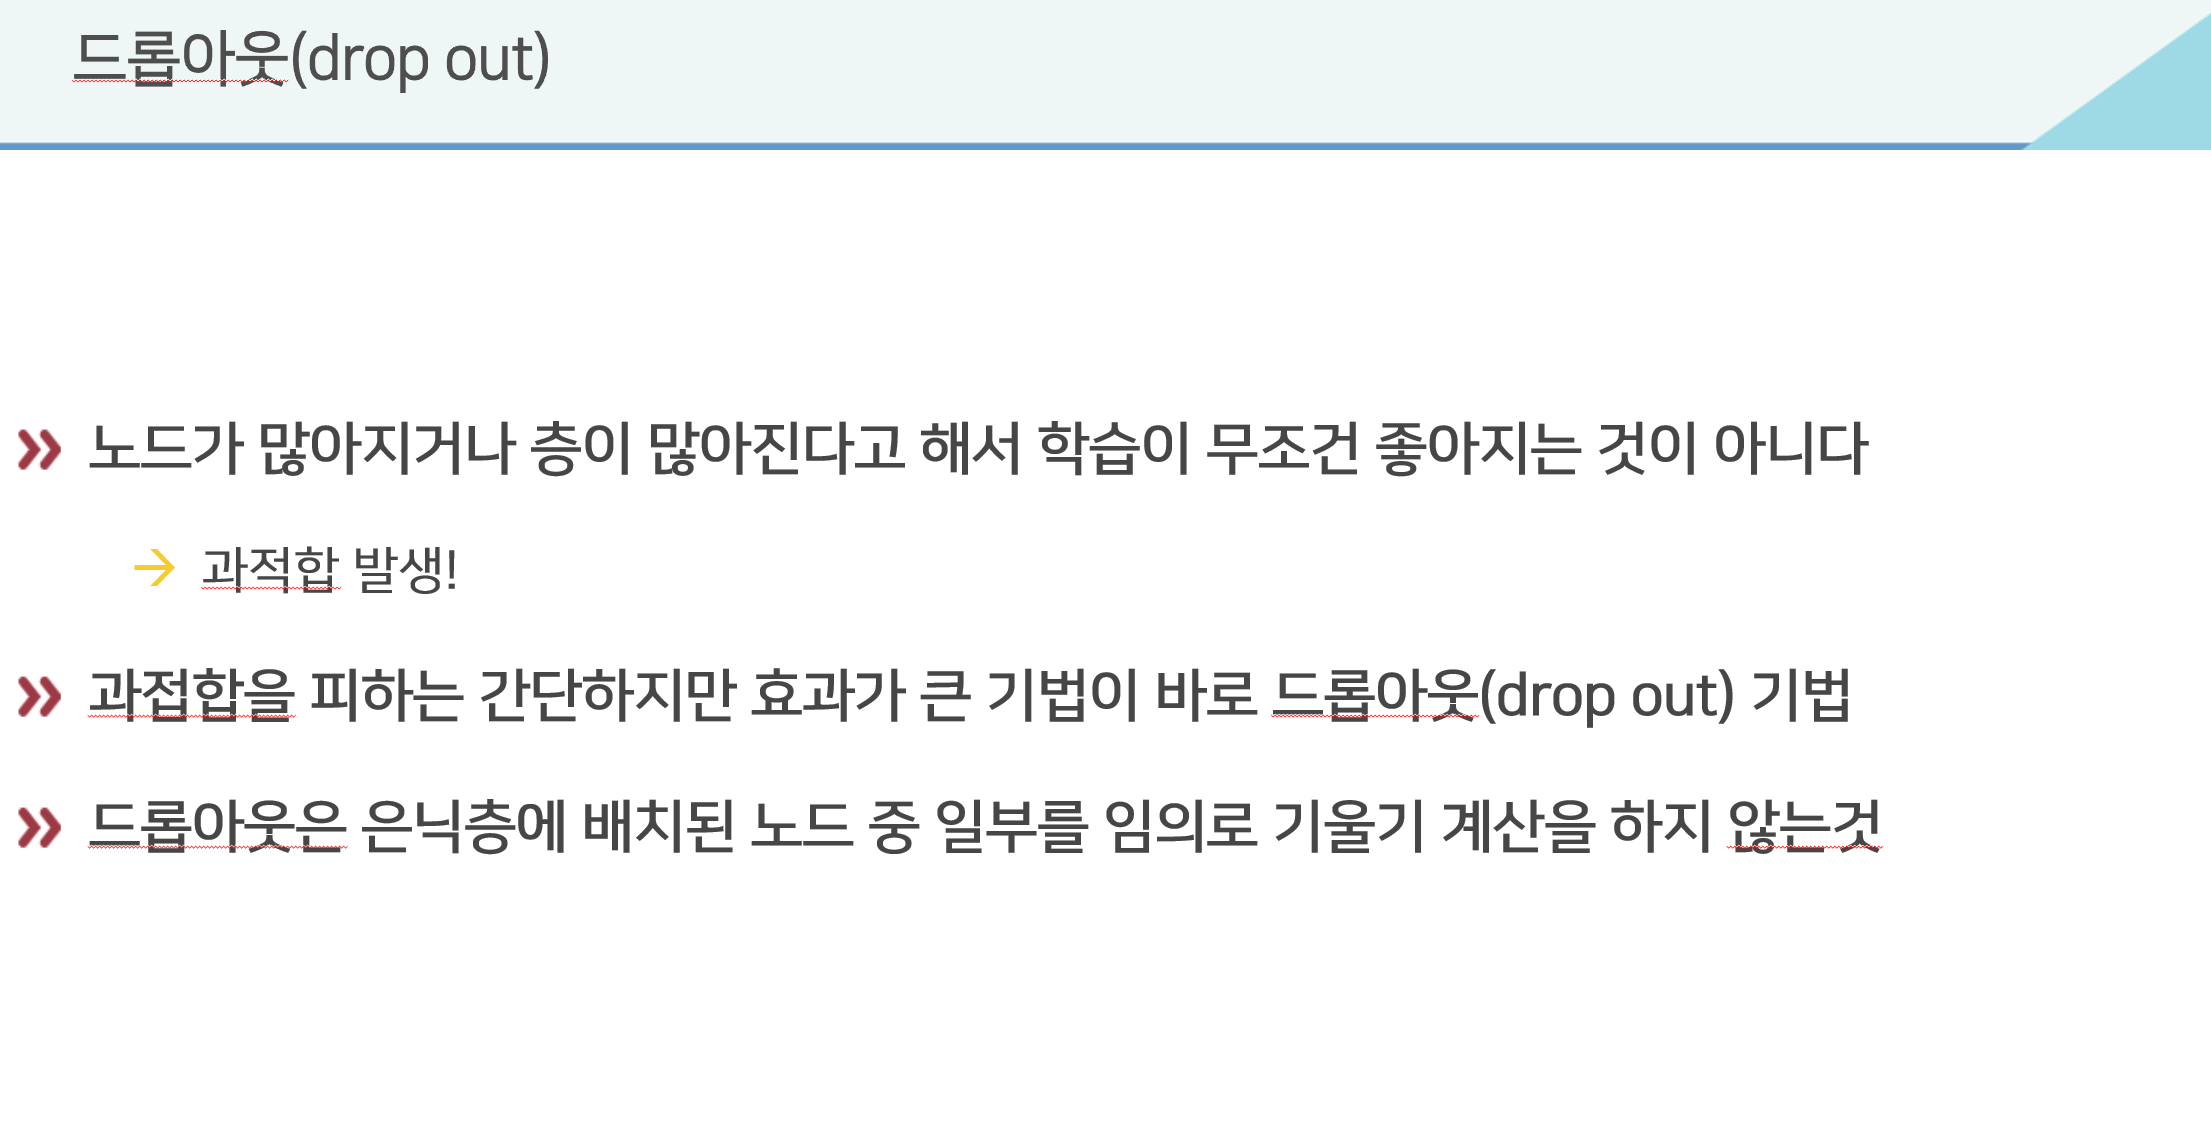

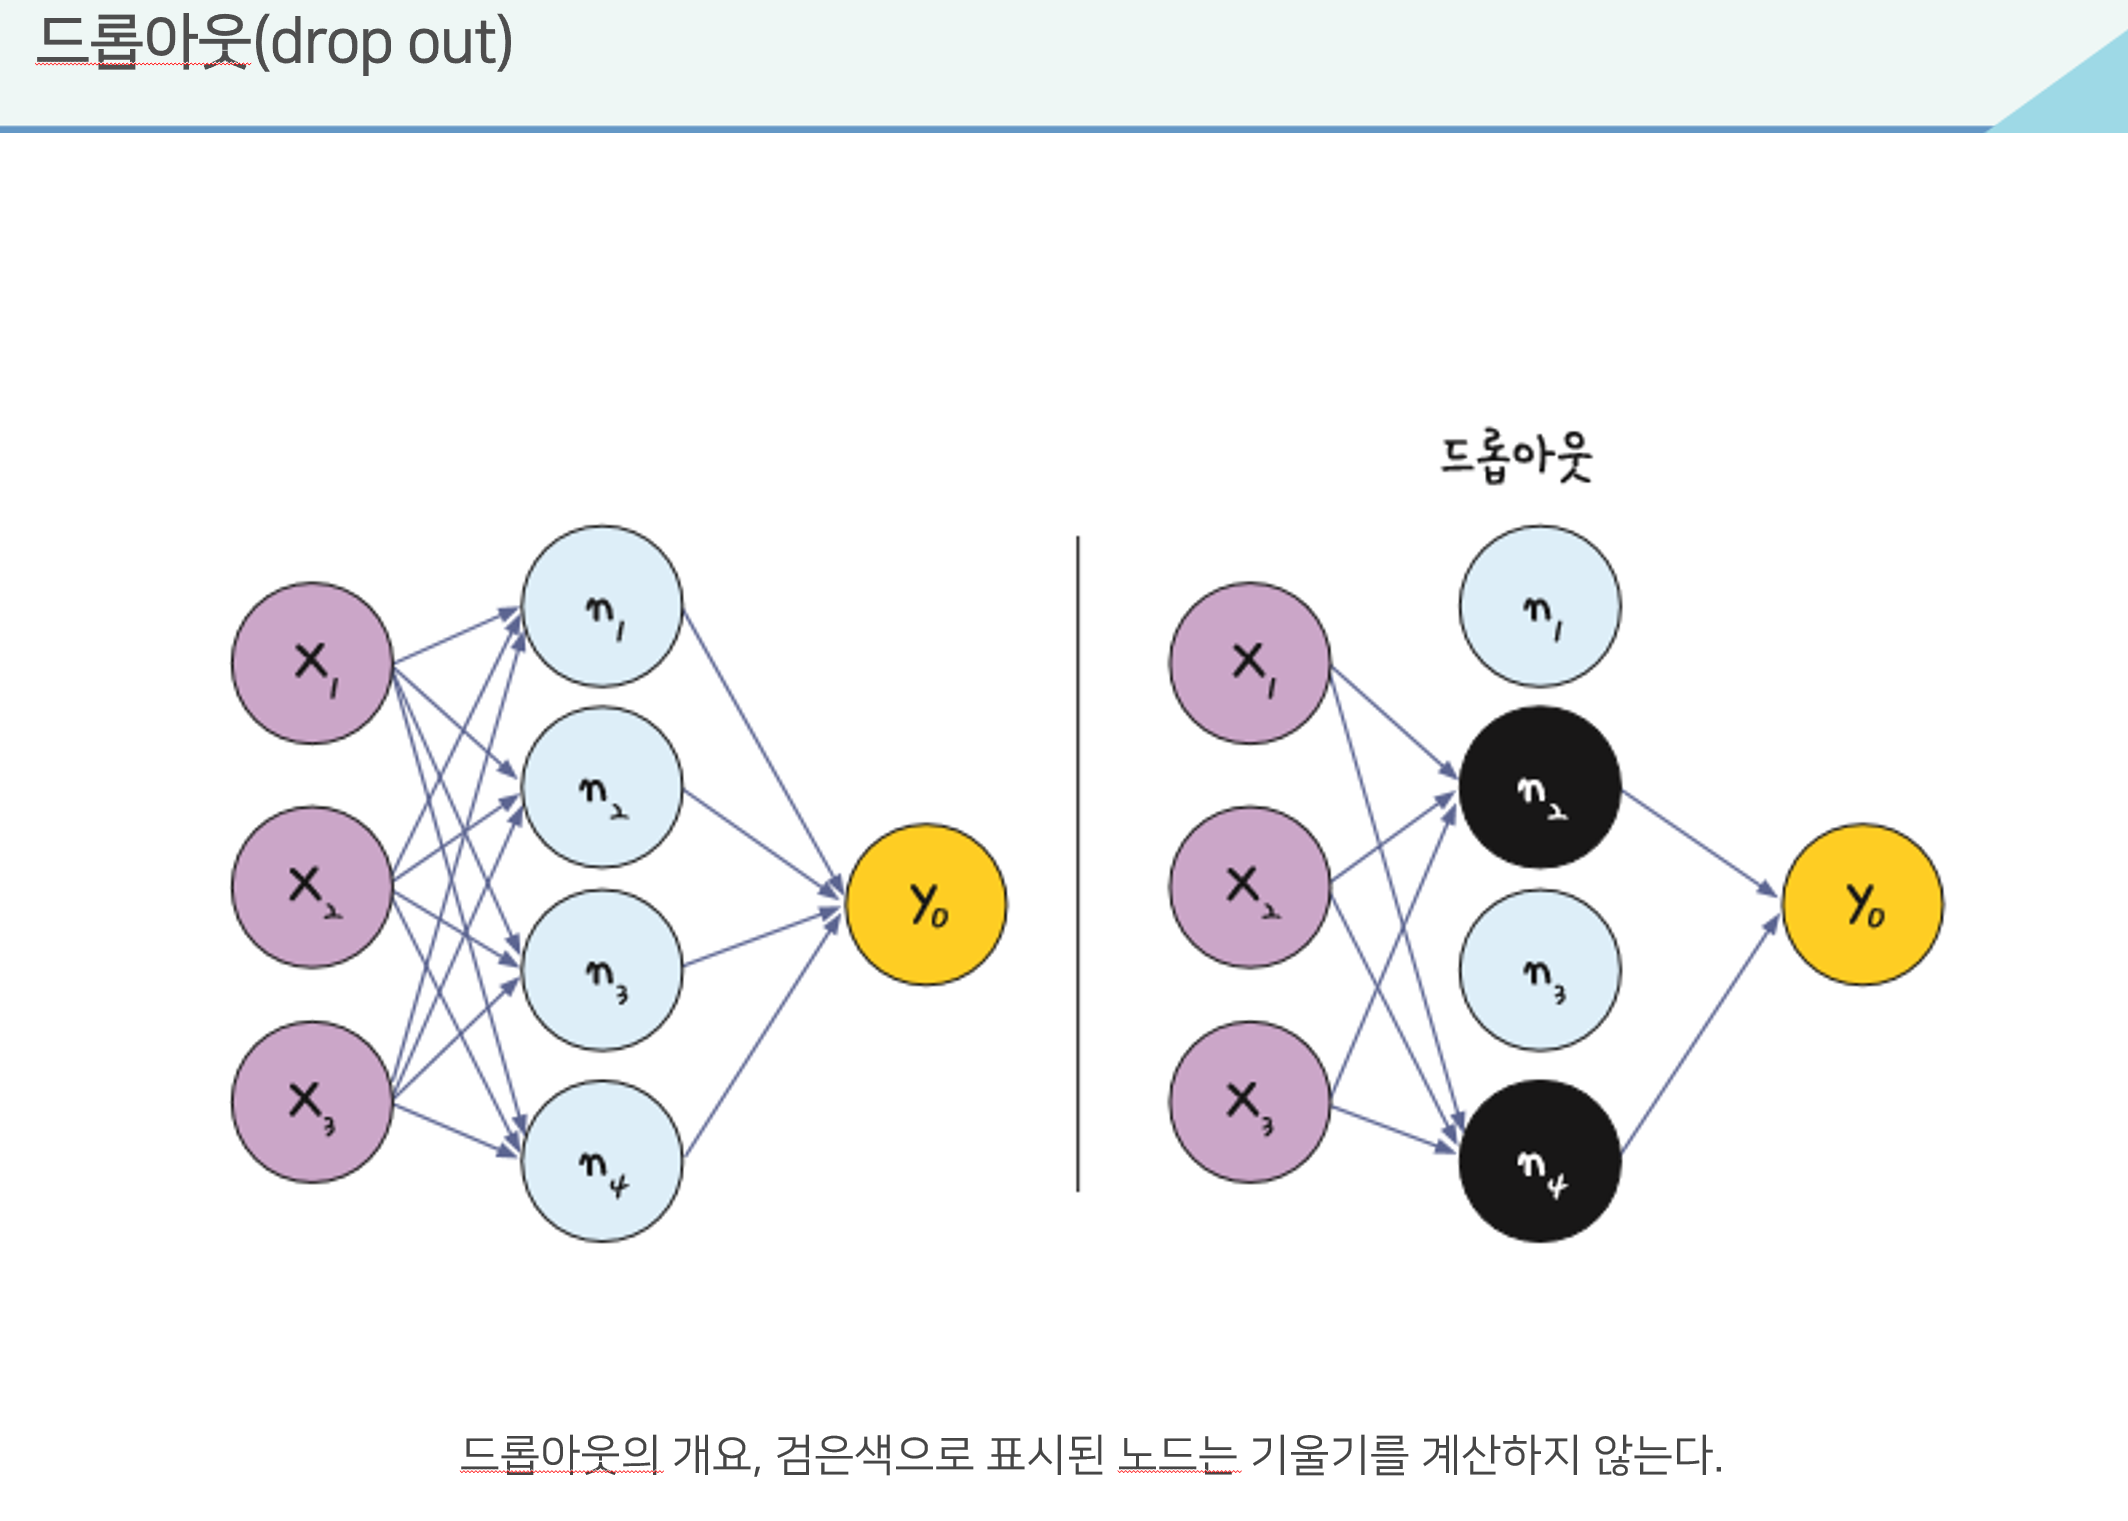

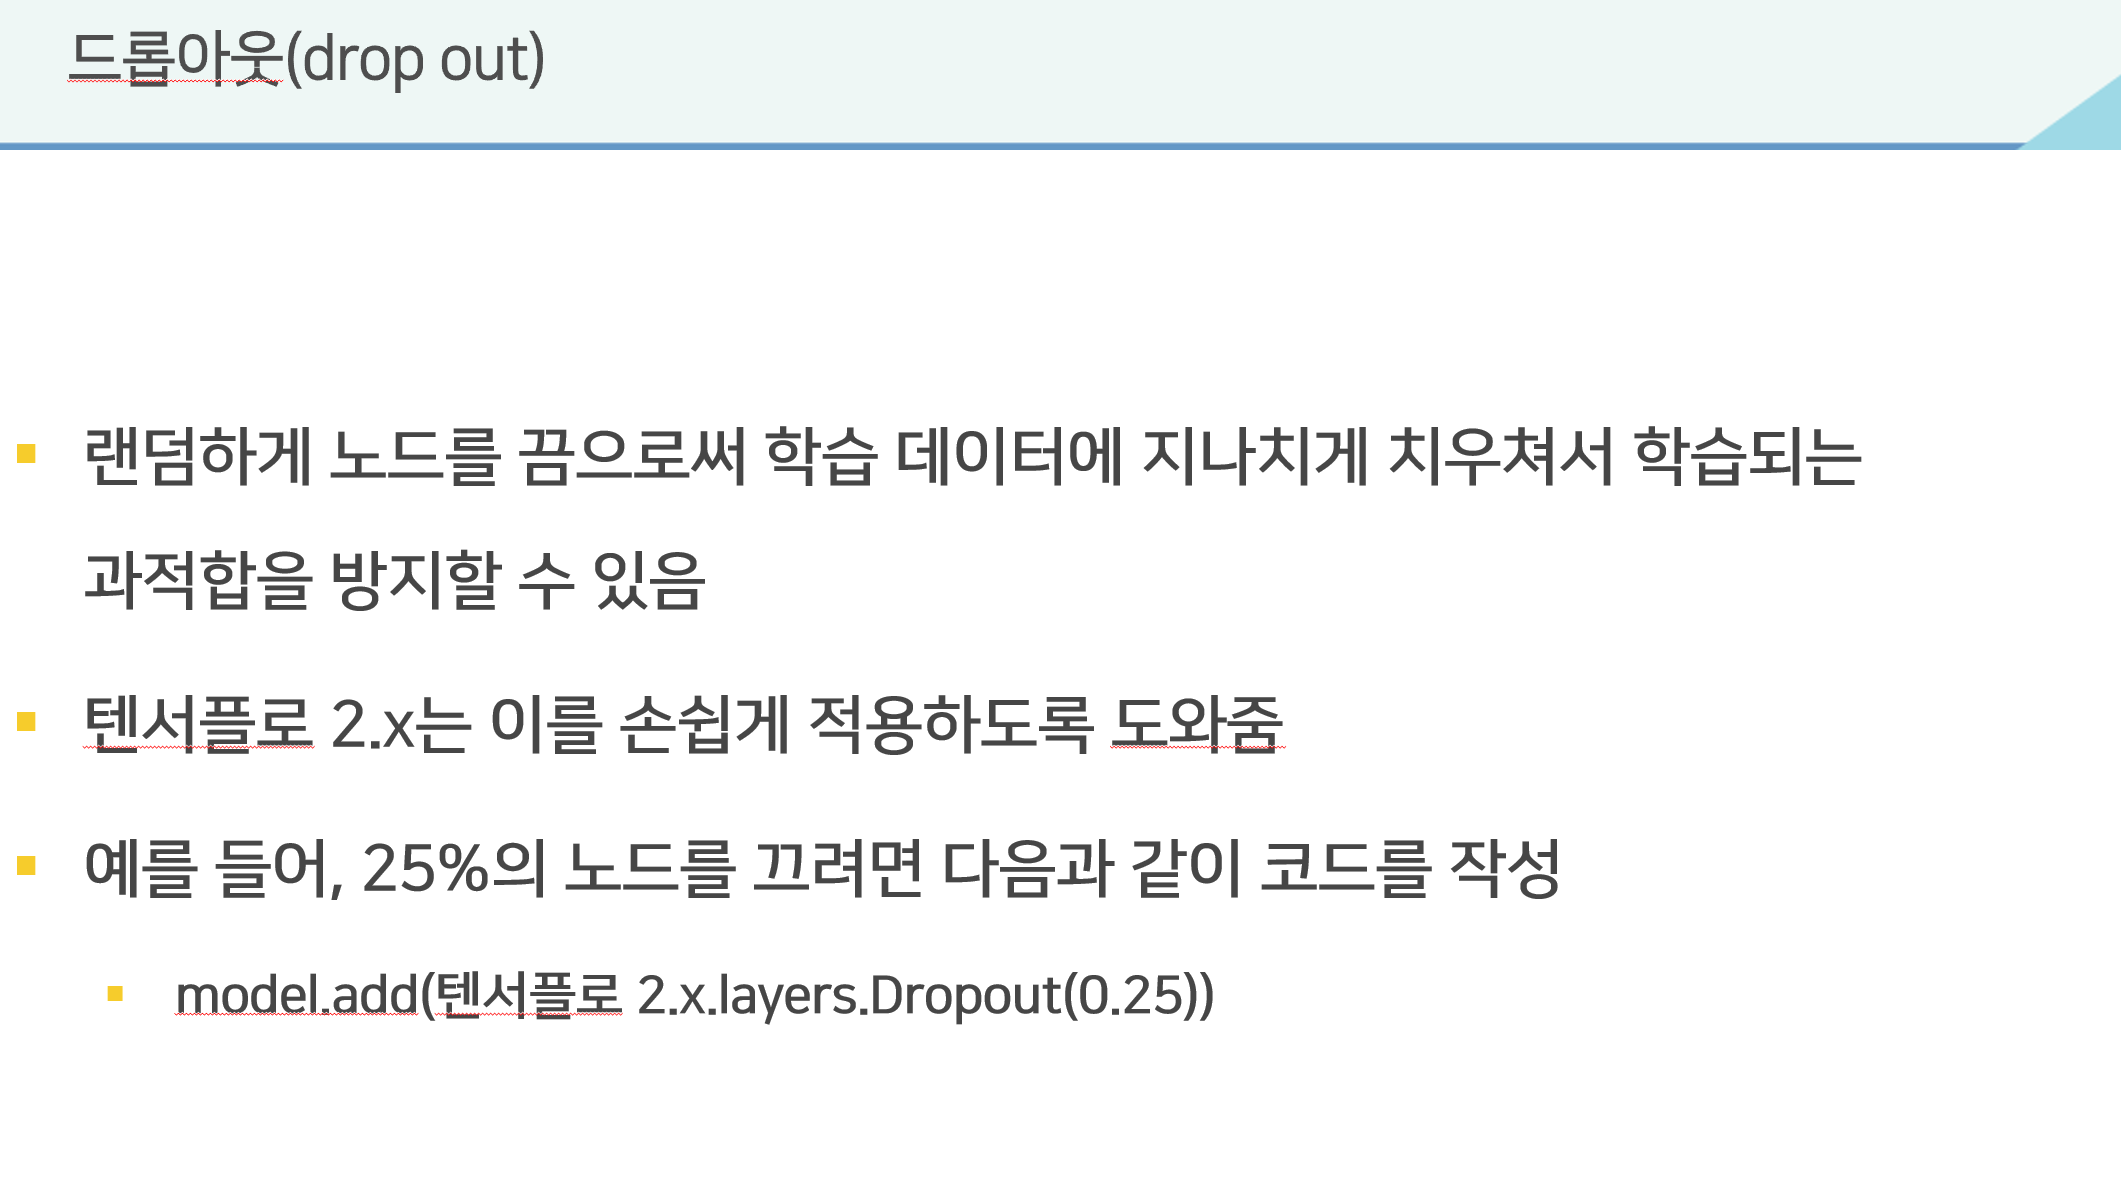

In [52]:
#전체 데이터 중 20%에 대해서만 기울기를 계산해서 수정
model.add(Dropout(0.8))

In [53]:
#Dense : 선형 회귀를 수행할 객체
#Dense(출력데이터의 칸의수) : 출력 데이터 칸의 수는 3이므로
#Dense(3)

#Dense(3) : 선형 회귀를 할 객체를 생성  출력 칸수는 3
    
# activation="softmax" :선형 회귀 후 softmax 함수를 활성 함수를 이용해서 다중분루  
    
    
#model.add(Dense(3, activation="softmax")):Dense 모델을 예측 할 수 있도록 model에 추가
model.add(Dense(3, activation="softmax"))

In [54]:
#생성된 모델 정보 출력
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 84,022,787
Trainable params: 25,691,139
Non-trainable params: 58,331,648
_________________________________________________________________


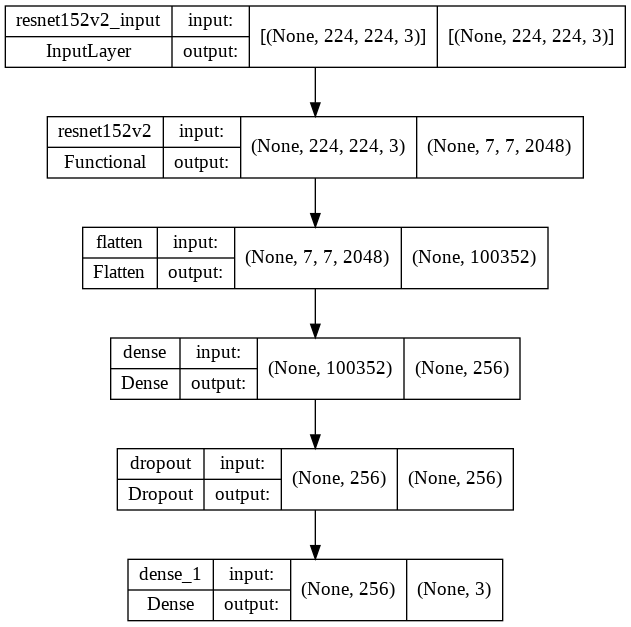

In [55]:
#model  모델 시각화
plot_model(model, show_shapes=True)

In [56]:
from tensorflow.keras.optimizers import Adam

In [57]:
#GradientDecnet를 이용해서 w1,w2,w3,w4를 찾는 방법을 설정함
#loss='categorical_crossentropy' : -(y * tf.log(hypothesis1)) 합 이 최소가 되는 w1,w2,w3,w4 를 찾음
#optimizer=Adam(lr=1e-4) : learning rate를 0.0001 로 설정
model.compile(
                  loss="categorical_crossentropy", 
                   optimizer=Adam(lr=1e-4),
                   metrics=["acc"]
              )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#이미지 증강

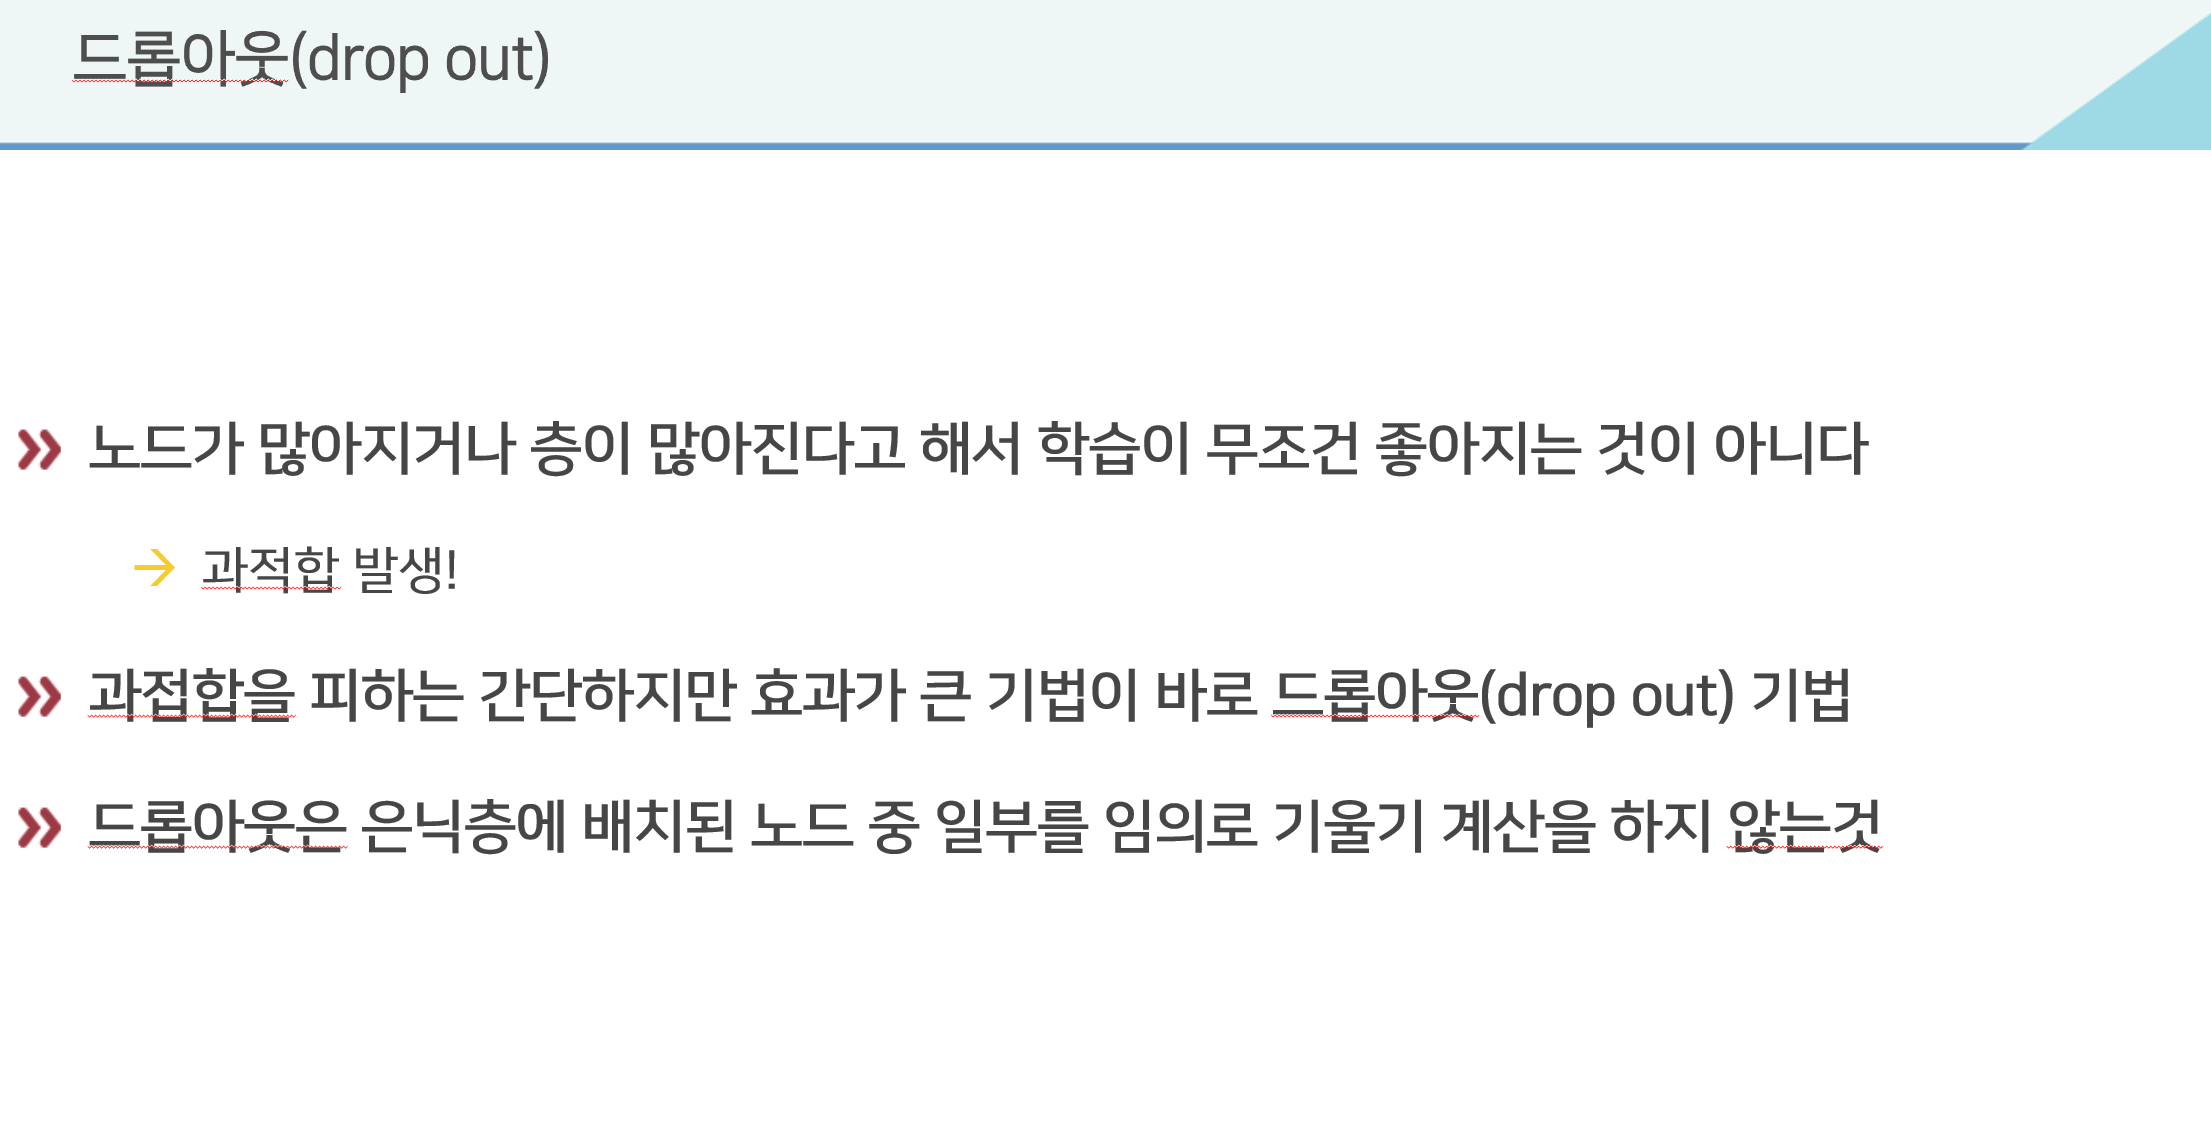

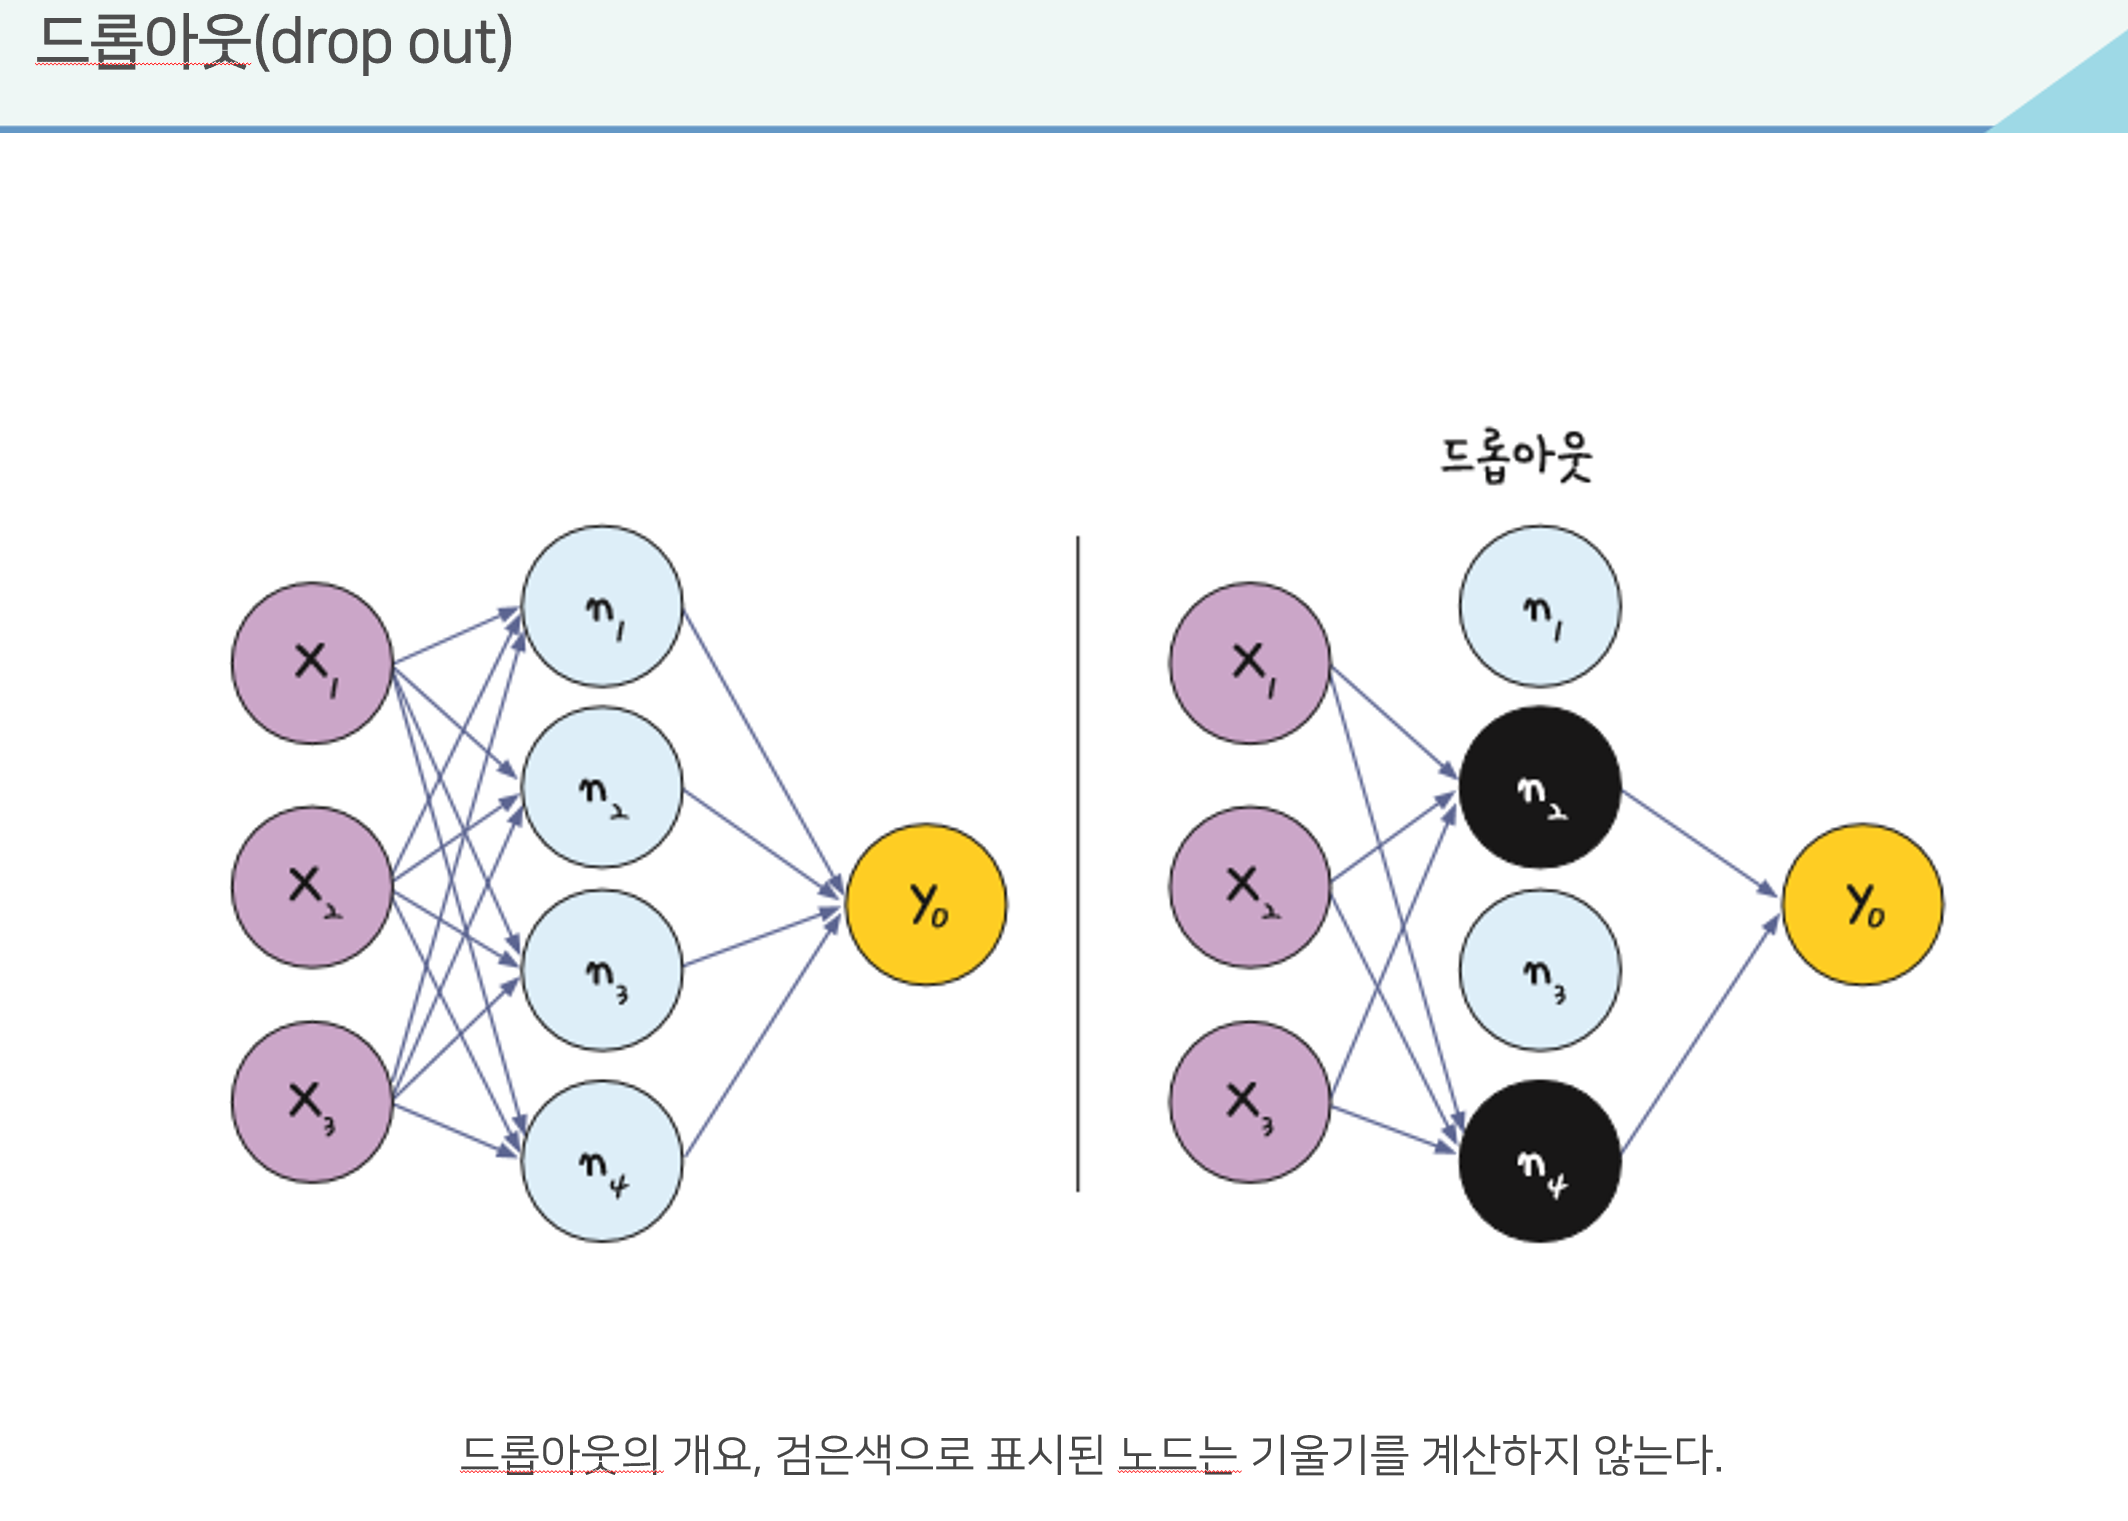

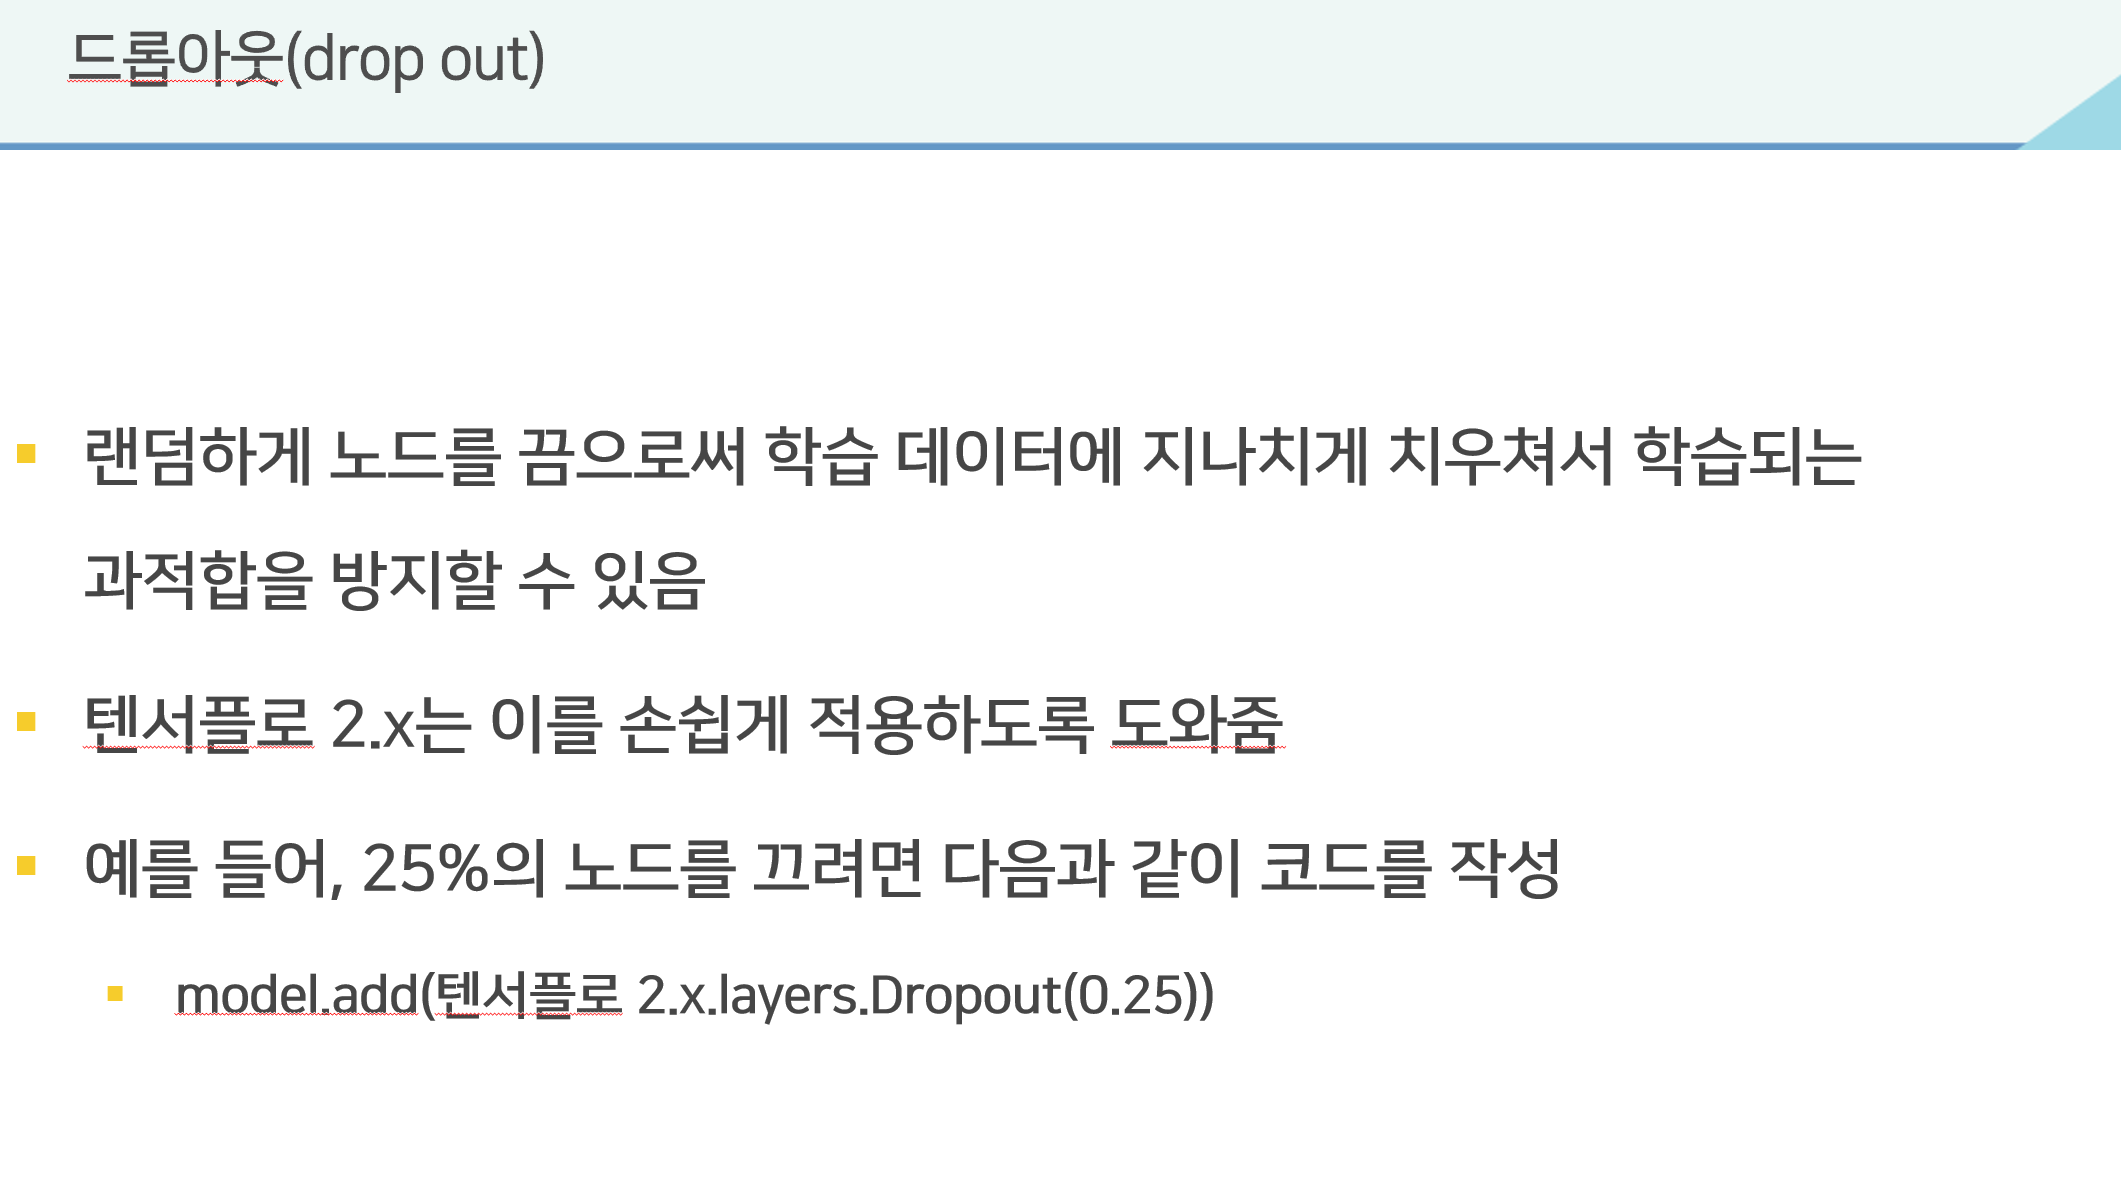

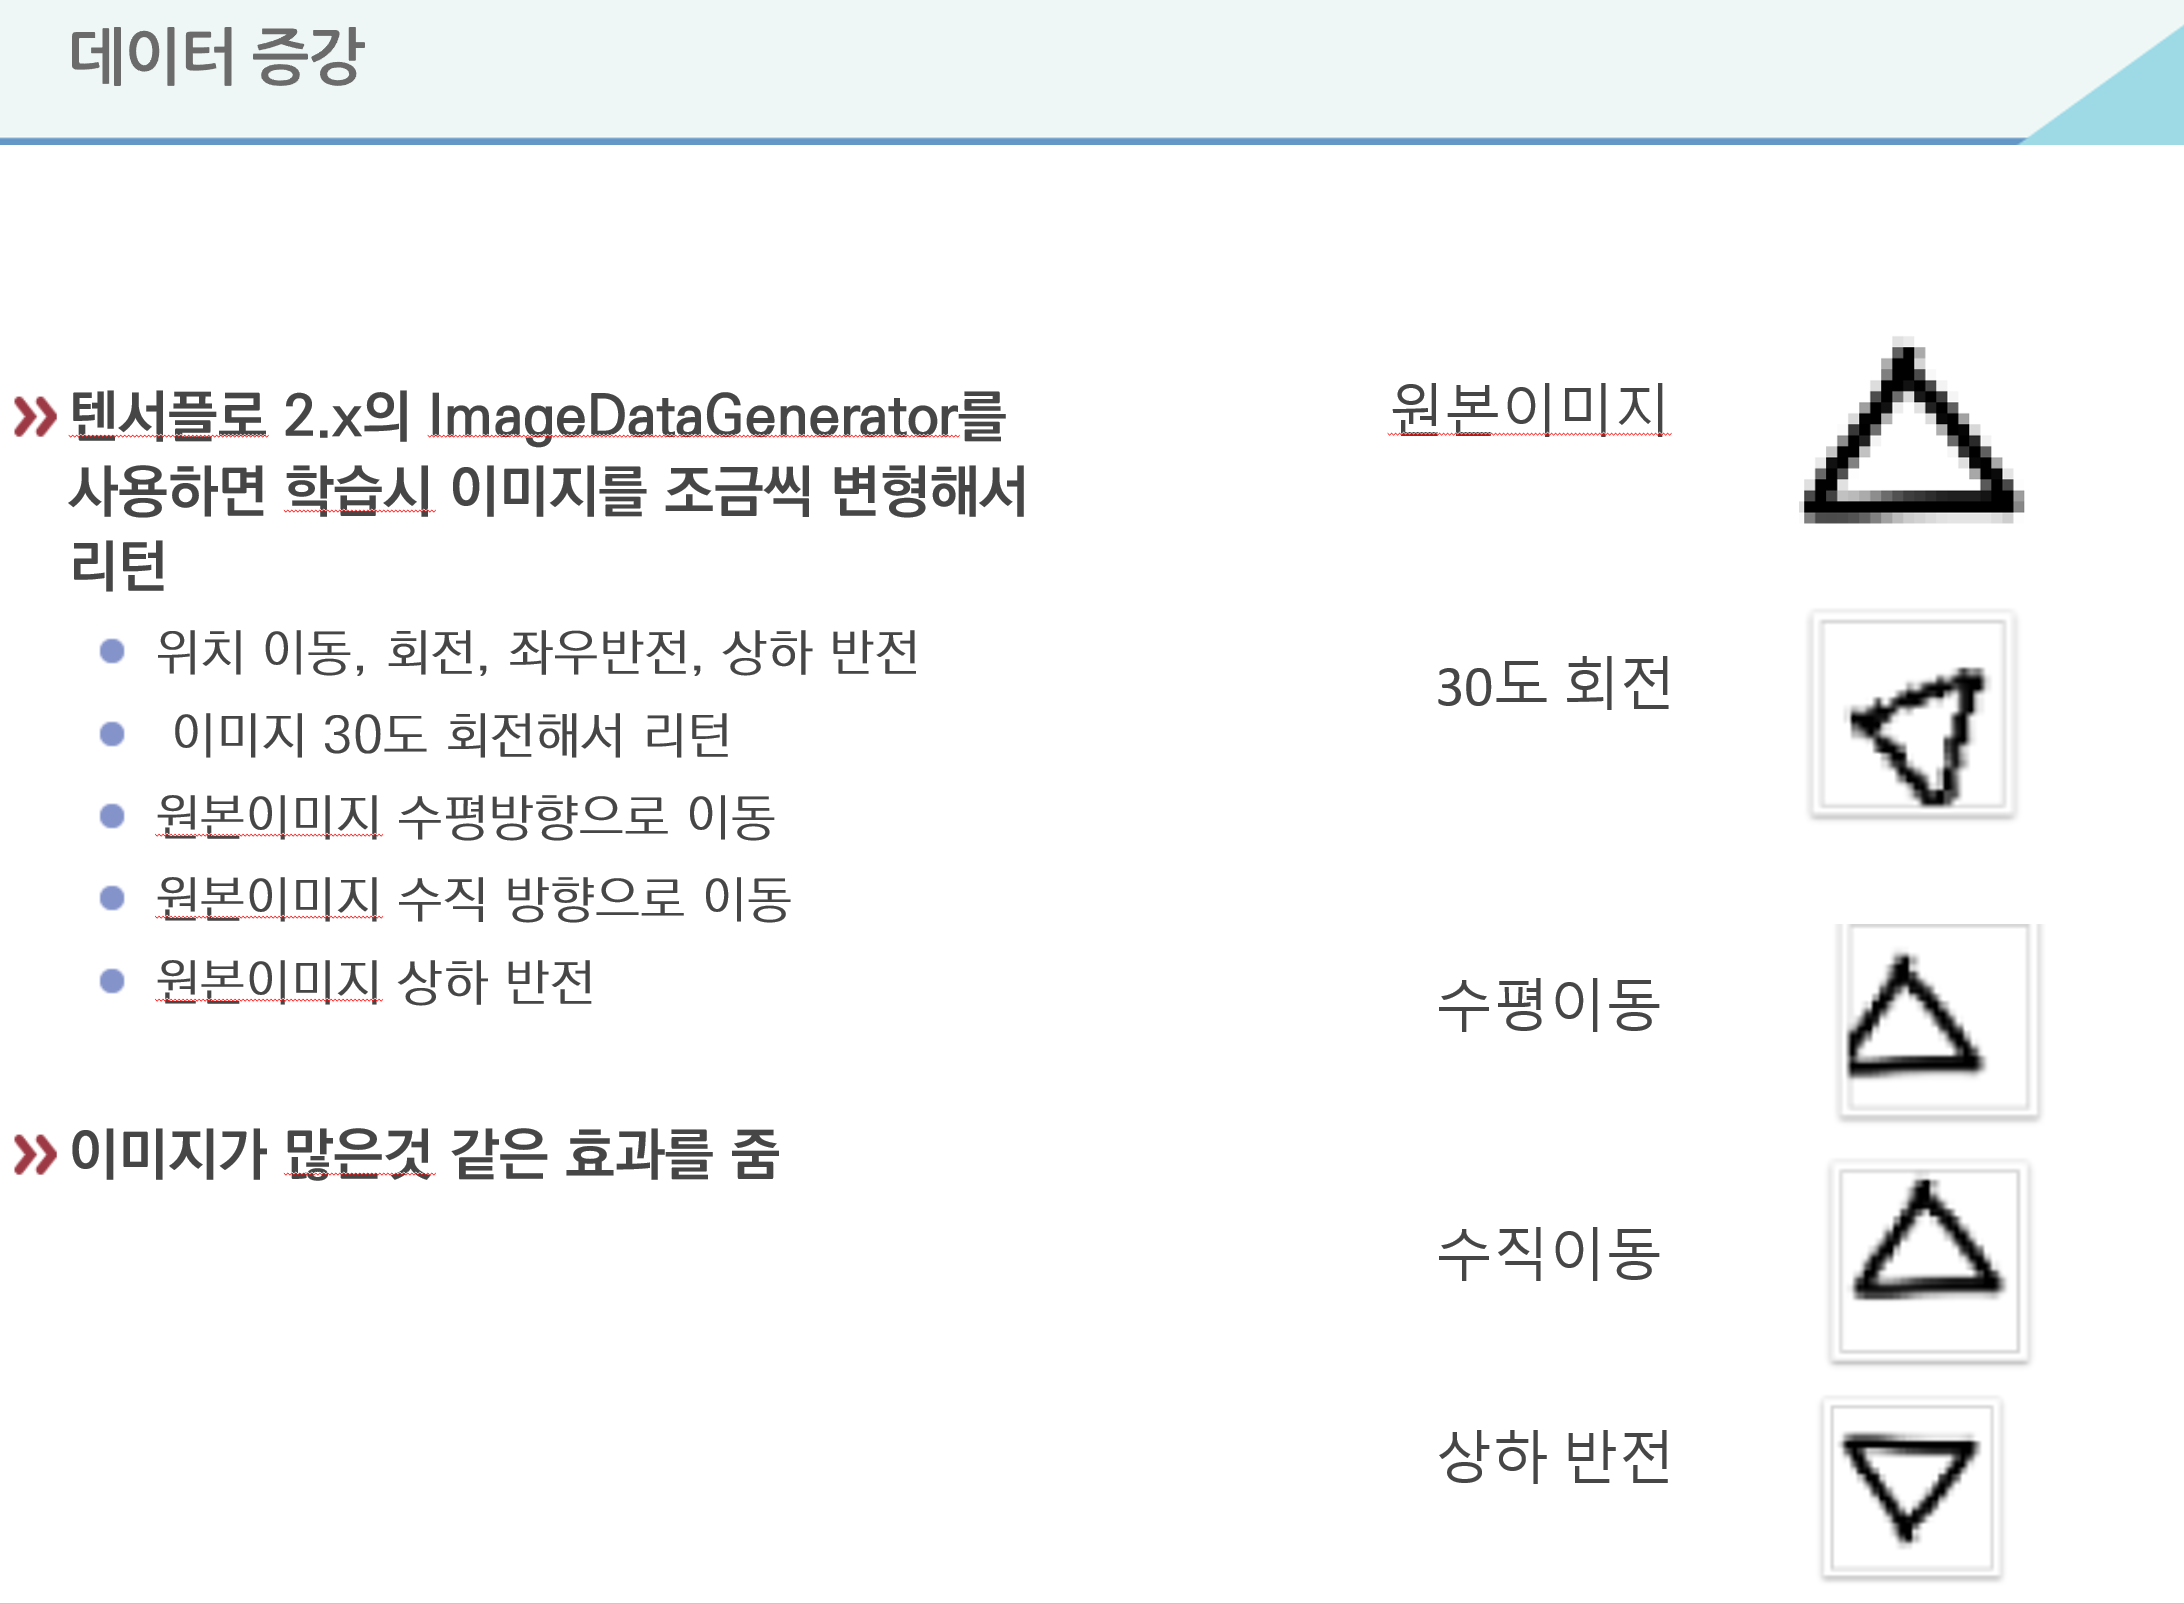

# 이미지를 증강해서 배치 사이즈 만큼씩 리턴하는 객체

# imgaug 설치

In [58]:
!pip install six numpy scipy Pillow matplotlib scikit-image opencv-python imageio Shapely

In [59]:
!pip install imgaug

In [60]:
import imgaug.augmenters as iaa

# 이미지를 증강해서 배치 사이즈 만큼씩 리턴하는 객체

In [61]:
import imgaug.augmenters as iaa

In [62]:
import imgaug as ia

In [63]:
# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.

seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.LinearContrast((0.5, 2.0))
                    )
                ]),
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)

In [64]:
seq

Sequential(name=UnnamedSequential, random_order=True, children=[Fliplr(name=UnnamedFliplr, parameters=[Binomial(Deterministic(float 0.50000000))], deterministic=False), Flipud(name=UnnamedFlipud, parameters=[Binomial(Deterministic(float 0.20000000))], deterministic=False), Sometimes(p=Binomial(Deterministic(float 0.50000000)), name=UnnamedSometimes, then_list=Sequential(name=UnnamedSometimes-then, random_order=False, children=[CropAndPad(name=UnnamedCropAndPad, parameters=[Uniform(Deterministic(float -0.05000000), Deterministic(float 0.10000000)), None, None, None, None, Choice(a=['minimum', 'edge', 'mean', 'median', 'reflect', 'wrap', 'maximum', 'constant', 'symmetric', 'linear_ramp'], replace=True, p=None), DiscreteUniform(Deterministic(int 0), Deterministic(int 255))], deterministic=False)], deterministic=False), else_list=None, deterministic=False), Sometimes(p=Binomial(Deterministic(float 0.50000000)), name=UnnamedSometimes, then_list=Sequential(name=UnnamedSometimes-then, random_

In [65]:
import math

In [66]:
# 이미지를 증강시켜서 배치 사이즈 만큼씩 리턴하는 클래스 구현

class  ImageSequence(tf.keras.utils.Sequence):
    # 객체 생성시 실행되는 함수
    # 매개변수
    # image_arr : 이미지가 저장된 배열
    # label_arr : 이미지의 종류가 저장된 배열
    # batch_size : 배치 사이즈 (한번에 리턴할 파일 개수)
    # seq : 이미지 증강 객체

    def __init__(self, image_arr ,label_arr, batch_size, seq):
        # 매개변수들을 속성에 저장
        self.image_arr  = image_arr 
        self.label_arr = label_arr
        self.batch_size = batch_size
        self.seq = seq
    
    # batch_size씩 이미지를 리턴했을때 전체 이미지를 리턴하려명 몆번 반복해야 하는지 리턴
    def __len__(self):
        
        # math.ceil : 소숫점 1자리 올림 예) 6.1 -> 7   6 -> 6   6.0 -> 6

        # image_arr  (이미지가 저장된 배열) / batch_size (한번에 리턴할 이미지 개수) 의 올림을 리턴     
        return math.ceil(len(self.image_arr ) / self.batch_size)

    # 학습시 batch_size 씩 이미지를 리턴하는 함수로 텐서플로우에서 학습시 model 객체에서 자동으로 호출하는 함수
    # 매개변수 idx : 몆번째 batch 인지가 저장되는 매개변수 0부터 시작
    def __getitem__(self, idx):
        # idx * self.batch_size 부터 (idx + 1) * self.batch_size 까지 이미지 리턴
        batch_image_arr = self.image_arr[idx * self.batch_size:(idx + 1) * self.batch_size]
        # 증강시키기 위해서 batch_image_arr을 정수로 변환
        img = np.array( batch_image_arr,  dtype=np.uint8)
        # img를 증강시켜서 generate_img에 저장
        generate_img = seq(images=img) 
        # idx * self.batch_size 부터 (idx + 1) * self.batch_size 까지 이미지 종류 리턴
        batch_label_arr = self.label_arr[idx * self.batch_size:(idx + 1) * self.batch_size]

        return generate_img/255.0, batch_label_arr
        

In [67]:
# ImageSequence : 객체 생성
# X_train : 이미지
# y_train : 이미지 라벨
# 32: 배치 사이즈
#seq : 이미지 증강 객체
train_sequence = ImageSequence(X_train, y_train, 32, seq)

In [68]:
# 이미지 학습
model.fit(
	#train_sequence가 리턴하는 증강된 이미지를 학습  
	train_sequence,
    # 5번 반복해서 전체 이미지 학습 
	epochs = 10)

/usr/local/lib/python3.7/dist-packages/imgaug/augmenters/segmentation.py:191: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments = segmentation.slic(image, n_segments=n_segments_samples[i], compactness=10)


Epoch 1/10
223/223 [==============================] - 148s 614ms/step - loss: 1.0344 - acc: 0.7596
Epoch 2/10
223/223 [==============================] - 146s 651ms/step - loss: 0.3525 - acc: 0.8691
Epoch 3/10
223/223 [==============================] - 138s 617ms/step - loss: 0.2864 - acc: 0.8940
Epoch 4/10
223/223 [==============================] - 137s 611ms/step - loss: 0.2407 - acc: 0.9053
Epoch 5/10
223/223 [==============================] - 141s 629ms/step - loss: 0.2294 - acc: 0.9187
Epoch 6/10
223/223 [==============================] - 142s 637ms/step - loss: 0.2205 - acc: 0.9236
Epoch 7/10
223/223 [==============================] - 143s 642ms/step - loss: 0.2109 - acc: 0.9225
Epoch 8/10
223/223 [==============================] - 144s 643ms/step - loss: 0.2072 - acc: 0.9292
Epoch 9/10
223/223 [==============================] - 141s 629ms/step - loss: 0.1822 - acc: 0.9346
Epoch 10/10
223/223 [==============================] - 142s 638ms/step - loss: 0.1782 - acc: 0.9341


In [69]:
# 학습한 ResNet152 모델 저장
model.save(data_path + "resnet_train.h5")